# Last Cycle
Now that the cycle stabilized we can cycle one more time to track relevant quantities:
- Mutual Information
- Work
- Heat
- Internal Energy (?)

In [1]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using ProgressBars
using Plots
using LaTeXStrings
# Saving the output matrix
using Serialization

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

plot_in_time (generic function with 1 method)

In [2]:
function _check(ρ)
    println("System after the stroke:")
    if !checkdensity(ρ)
        throw(DomainError(ρ))
    end
    println("Final Temperature of the System: $(Measurements.temperature(ρ, ω))")
end


function bosonic_operators(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    return [C, Cp, S, Sd]
end


function measure_and_plot(system_evolution, cavity_evolution, title)
    temperatures = []
    entropies = []
    for (i, ρ) in enumerate(system_evolution)
        cavity_len = cavity_evolution isa Real ? cavity_evolution : cavity_evolution[i]
        local ω = α0 / cavity_len
        t = round(Measurements.temperature(ρ, ω), digits=5)
        ent = round(Measurements.entropy_vn(ρ), digits=5)
        
        push!(temperatures, t)
        push!(entropies, ent)
    end

    g = plot(entropies, temperatures, label="Stroke")
        
    # Plot starting point
    scatter!(g, [entropies[1]], [temperatures[1]], label="Start", mc="blue", ms=5)
    # Plot ending point
    scatter!(g, [entropies[end]], [temperatures[end]], label="End", mc="red", ms=5)
    title!(title)
    xlabel!("Entropy")
    ylabel!("Temperature")
    
    return g
end

function plot_in_time(system_evolution, cavity_evolution, label, title; g=nothing)
    temperatures = []
    for (i, ρ) in enumerate(system_evolution)
        cavity_len = cavity_evolution isa Real ? cavity_evolution : cavity_evolution[i]
        local ω = α0 / cavity_len
        t = round(Measurements.temperature(ρ, ω), digits=5)        
        push!(temperatures, t)
    end

    if isnothing(g)
        g = plot(temperatures, label=label)
    else
        plot!(temperatures, label=label)
    end
    
    title!(title)
    xlabel!("Time")
    ylabel!("Temperature")

    return g
    
end
;

In [3]:
const NDIMS = 25
const Ω = 5.0
const Δt = 1e-2

const T_initial = 7.0  # Can be lower
const T_heating = 8.0
const T_cooling = 5.0

# Create a Cavity
const α0 = π
const l0 = 1.0
const expanding_force = 0.5
const compressing_force = 2.5
cavity1 = Cavity(1.0, 1.0, l0, α0, expanding_force)
cavity2 = Cavity(1.0, 1.0, l0, α0, expanding_force)
ω = α0 / l0

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")
# Joint system
ρ_tot = kron(ρt, ρt)

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h, ω) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

bosonic_h = bosonic_operators(α_h, ϕ_h)

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c, ω) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

bosonic_c = bosonic_operators(α_c, ϕ_c);

system_evolution = []
;

Initial Temperature of the Cavity:
    6.999999999999999
Apparent Temperature carried by Hot Phaseonium atoms: 
    7.999999999999995
Apparent Temperature carried by Cold Phaseonium atoms: 
    5.000000000000002


### Load or Create State

In [4]:
# Check number of photons and cutoff
println(tr(ρt*ad*a))
println(ρt[end])

1.7651090641035214
7.592401084517699e-6


In [5]:
state = deserialize("state_cascade_nonthermal_2photons_50cycles");

In [6]:
# Reinitialize memory
state.ρ₁_evolution = [] 
state.ρ₂_evolution = []
state.c₁_evolution = []
state.c₂_evolution = [];

In [25]:
function _phaseonium_stroke(state::StrokeState, time, bosonic, ga, gb, ss)
    stroke_evolution = Thermodynamics.phaseonium_stroke_2(
        state.ρ, time, bosonic, ga, gb; 
        sampling_steps=ss, verbose=2)

    ρ₁_evolution = [partial_trace(real(ρ), (NDIMS, NDIMS), 1) for ρ in stroke_evolution]
    ρ₂_evolution = [partial_trace(real(ρ), (NDIMS, NDIMS), 2) for ρ in stroke_evolution]
    c₁_lengths = [state.c₁.length for _ in stroke_evolution]
    c₂_lengths = [state.c₂.length for _ in stroke_evolution]
    
    append!(state.ρ₁_evolution, ρ₁_evolution)
    append!(state.ρ₂_evolution, ρ₂_evolution)
    append!(state.c₁_evolution, c₁_lengths)
    append!(state.c₂_evolution, c₂_lengths)
    
    state.ρ = real(chop!(stroke_evolution[end]))
    return state, stroke_evolution
end


function _adiabatic_stroke(state::StrokeState, time, Δt, jumps, ss)
    stroke_evolution, cavity_motion = Thermodynamics.adiabatic_stroke_2(
        state.ρ, [state.c₁, state.c₂], time, Δt, jumps;
        sampling_steps=ss, verbose=2)

    ρ₁_evolution = [partial_trace(real(ρ), (NDIMS, NDIMS), 1) for ρ in stroke_evolution]
    ρ₂_evolution = [partial_trace(real(ρ), (NDIMS, NDIMS), 2) for ρ in stroke_evolution]
    c₁_lengths = [l1 for (l1, _) in cavity_motion]
    c₂_lengths = [l2 for (_, l2) in cavity_motion]
    
    append!(state.ρ₁_evolution, ρ₁_evolution)
    append!(state.ρ₂_evolution, ρ₂_evolution)
    append!(state.c₁_evolution, c₁_lengths)
    append!(state.c₂_evolution, c₂_lengths)
    
    state.ρ = real(chop!(stroke_evolution[end]))
    state.c₁.length = cavity_motion[end][1]
    state.c₂.length = cavity_motion[end][2]
    return state, stroke_evolution
end    

function cycle(state, system_evolutions, isochore_t, isochore_samplings, adiabatic_t, adiabatic_samplings)
    if state isa Vector
        ρ, c₁, c₂ = state
        state = StrokeState(Matrix(ρ), c₁, c₂)
    end
    
    # Isochoric Heating
    state, system_evolution = _phaseonium_stroke(state, isochore_t, bosonic_h, ga_h, gb_h, isochore_samplings)
    append!(system_evolutions, system_evolution)
    # Adiabatic Expansion
    state, system_evolution = _adiabatic_stroke(state, adiabatic_t, Δt, [a, ad], adiabatic_samplings)
    append!(system_evolutions, system_evolution)
    # Isochoric Cooling
    state, system_evolution = _phaseonium_stroke(state, isochore_t, bosonic_c, ga_c, gb_c, isochore_samplings)
    append!(system_evolutions, system_evolution)
    # Adiabatic Compression
    state, system_evolution = _adiabatic_stroke(state, adiabatic_t, Δt, [a, ad], adiabatic_samplings)
    append!(system_evolutions, system_evolution)
    
    return state, system_evolutions
end

cycle (generic function with 1 method)

### Cycle

Isochoric Stroke


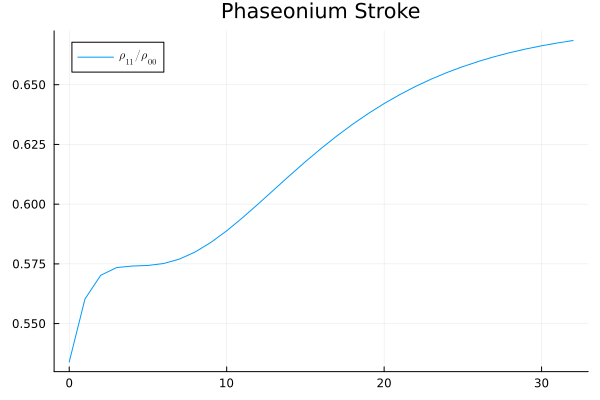

Adiabatic Stroke


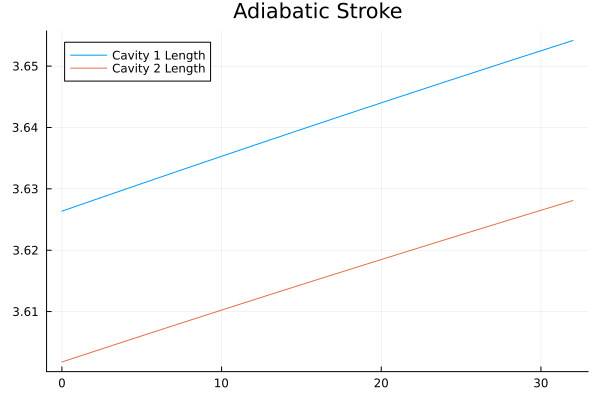

Isochoric Stroke


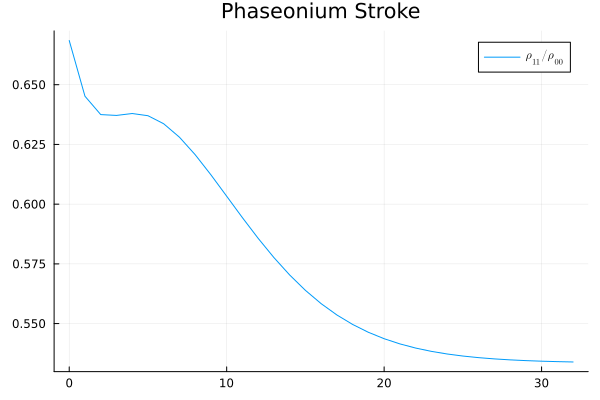

Adiabatic Stroke


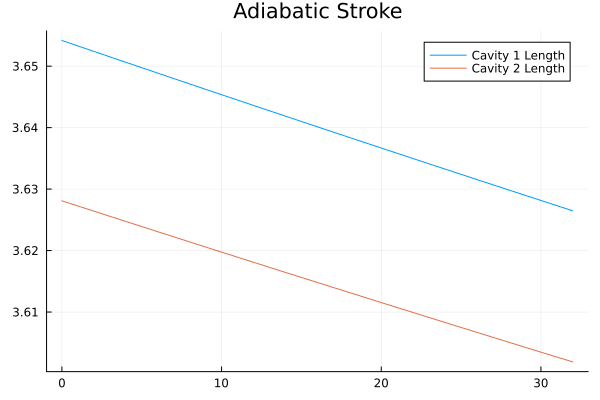

In [26]:
ρ = kron(ρt, ρt)
isochore_time = 8000
isochore_samplings = 32
adiabatic_time = 5000
adiabatic_samplings = 32

total_cycle_time = isochore_samplings * 2 + 2 * adiabatic_samplings + 4

# One Cycle
state, system_evolution = cycle(state, system_evolution, isochore_time, isochore_samplings, adiabatic_time, adiabatic_samplings);

In [27]:
size(system_evolution)

(165,)

### Save State

In [10]:
serialize("state_cascade_nonthermal_2photons_35cycles", state);

### Load State

In [11]:
# state = deserialize("4cycle_state_cascade_nonthermal_6cycles");

---
## Plot Evolution

In [12]:
1:total_cycle_time:length(state.ρ₁_evolution)+1

1:132:133

In [13]:
function rectangle(x, w, h)
    Shape([
            (x, 0),
            (x, h),
            (x+w, h),
            (x+w, 0)
    ])
end

rectangle (generic function with 1 method)

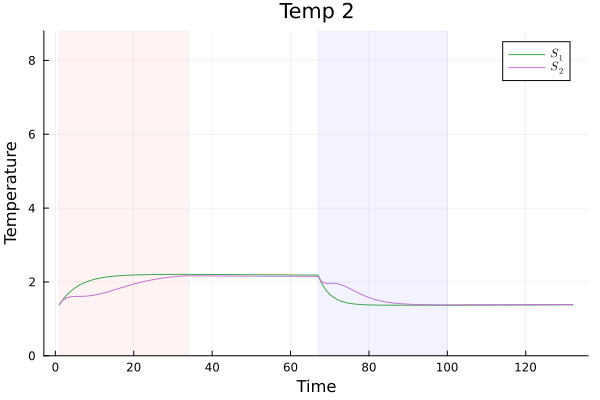

In [14]:
# vline!(1:total_cycle_time-1:length(state.ρ₂_evolution), line=:dash, color=:gray)
heating_distance = 2 * (isochore_samplings+adiabatic_samplings) + 4
isochore_strokes = 1:heating_distance:length(state.ρ₂_evolution)
adiabatic_strokes = isochore_samplings+3+adiabatic_samplings:isochore_samplings+adiabatic_samplings:length(state.ρ₂_evolution)
y_max = T_heating + 0.1 * T_heating
g = plot()
for left in isochore_strokes
    plot!(rectangle(left, isochore_samplings+1, y_max), fillcolor=:red, alpha=0.05, label=false)
    left_cooling = left+isochore_samplings+adiabatic_samplings+2
    plot!(rectangle(left_cooling, isochore_samplings+1, y_max), fillcolor=:blue, alpha=0.05, label=false)
end
g1 = plot_in_time(state.ρ₁_evolution, state.c₁_evolution, L"S_1", "Temp 1"; g=g);
g2 = plot_in_time(state.ρ₂_evolution, state.c₂_evolution, L"S_2", "Temp 2"; g=g1)
# xlims!(0, 100)
ylims!(0, y_max)
# vline!(isochore_strokes, line=:dash, color=:red)
# vline!(adiabatic_strokes, line=:dash, color=:blue)

In [15]:
# savefig(g2, "Temp_vs_Time_cascade_fastcycle.png");

In [16]:
measure_and_plot(state.ρ₁_evolution[end-total_cycle_time:end], state.c₁_evolution[end-total_cycle_time:end], "Cycle 1 last round")

LoadError: BoundsError: attempt to access 132-element Vector{Matrix{Float64}} at index [0:132]

In [17]:
# savefig("Temp_vs_Time_cascade_1_fastcycle.png")

In [18]:
measure_and_plot(state.ρ₂_evolution[end-total_cycle_time:end], state.c₂_evolution[end-total_cycle_time:end], "Cycle 2 last round")

LoadError: BoundsError: attempt to access 132-element Vector{Matrix{Float64}} at index [0:132]

In [19]:
# savefig("Temp_vs_Time_cascade_2_fastcycle.png")